# Binary Stars in our Sample
Red Supergiants (RSG) in binary systems typically have an OB star companion which presents itself in a spectra with an upturn in the blue (3000-4000 Å). Since we are trying to identify stars that were previously in the RSG phase, we want to find these OB stars in the our stars.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob 
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
from astropy import units as u
from astropy import constants as const
import pandas as pd
import warnings
from astropy import stats as st

## Preliminary Functions

In [2]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')

# sort mcfiles to the order files is in
mcfiles_sorted = [] # create empty list
# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])

In [3]:
df = pd.read_csv('/Users/kchen/Downloads/ysg.csv') # read csv

In [4]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]

    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('This graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    #print(specdata)
    
    #print(spec1d)
    return spec1d
    

In [5]:
def smooth(i):
    """
    Smooths the data for graph i so that it is easier to see the continuum and match the model to the data.
    """
    spec1d = fitsfile(i)
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    #print(spec_interp)
    return spec_interp, spec1d

In [6]:
def loademcee(i):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=1000)
    return samples

In [7]:
def ssp(theta):
    """
    plots a stsynphot graph based on a theta that holds the values of t_eff, log_g, rv, ebv, radius
    """
    t_eff, log_g, rv, ebv, radius = theta # unpack theta
    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) # model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) # speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) # average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2
    
    return reddenedmodel_flux

## Plotting Residuals
Since our best fit spectra are for single star systems, we can compare the models and data to find this upturn in the blue that isn't captured by models. It isn't relevant to create models for two star systems because the OB star is very small in comparison to the RSG, so the RSG dominates the majority of the spectrum. We can eccentuate this upturn by creating residual graphs.

In [8]:
import cmasher as cmr
my_cmap = cmr.bubblegum
data_color = my_cmap(0)
emcee_color = my_cmap(170)
resid_color = my_cmap((.6-1e-14)/2)
def binary(wavelength, i):
    """
    Takes an array of wavelength points and graph number i and 
    outputs 
    """
    # unpack values from smoothed data and loademcee
    spec_interp, spec1d = smooth(i)
    samples = loademcee(i) # unpack

    
    # calculate the graph from emcee median
    teff=np.percentile(samples[:,0], [50])
    logg=np.percentile(samples[:,1], [50])
    rv=np.percentile(samples[:,2], [50])[0]
    ebv=np.percentile(samples[:,3], [50])[0]
    rad=np.percentile(samples[:,4], [50])
    
    theta = [teff, logg, rv, ebv, rad]
    reddenedmodel_flux = ssp(theta)


    y_value = (spec_interp.flux.value-reddenedmodel_flux.value)/reddenedmodel_flux.value

    ax = plt.subplots(dpi=300)[1]
    ax.plot(wavelength, y_value, alpha=1, color=resid_color)
    ax.set_ylabel('Relative Residual Flux', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    plt.show()



This graph is: j05344_122722.fits and array 20


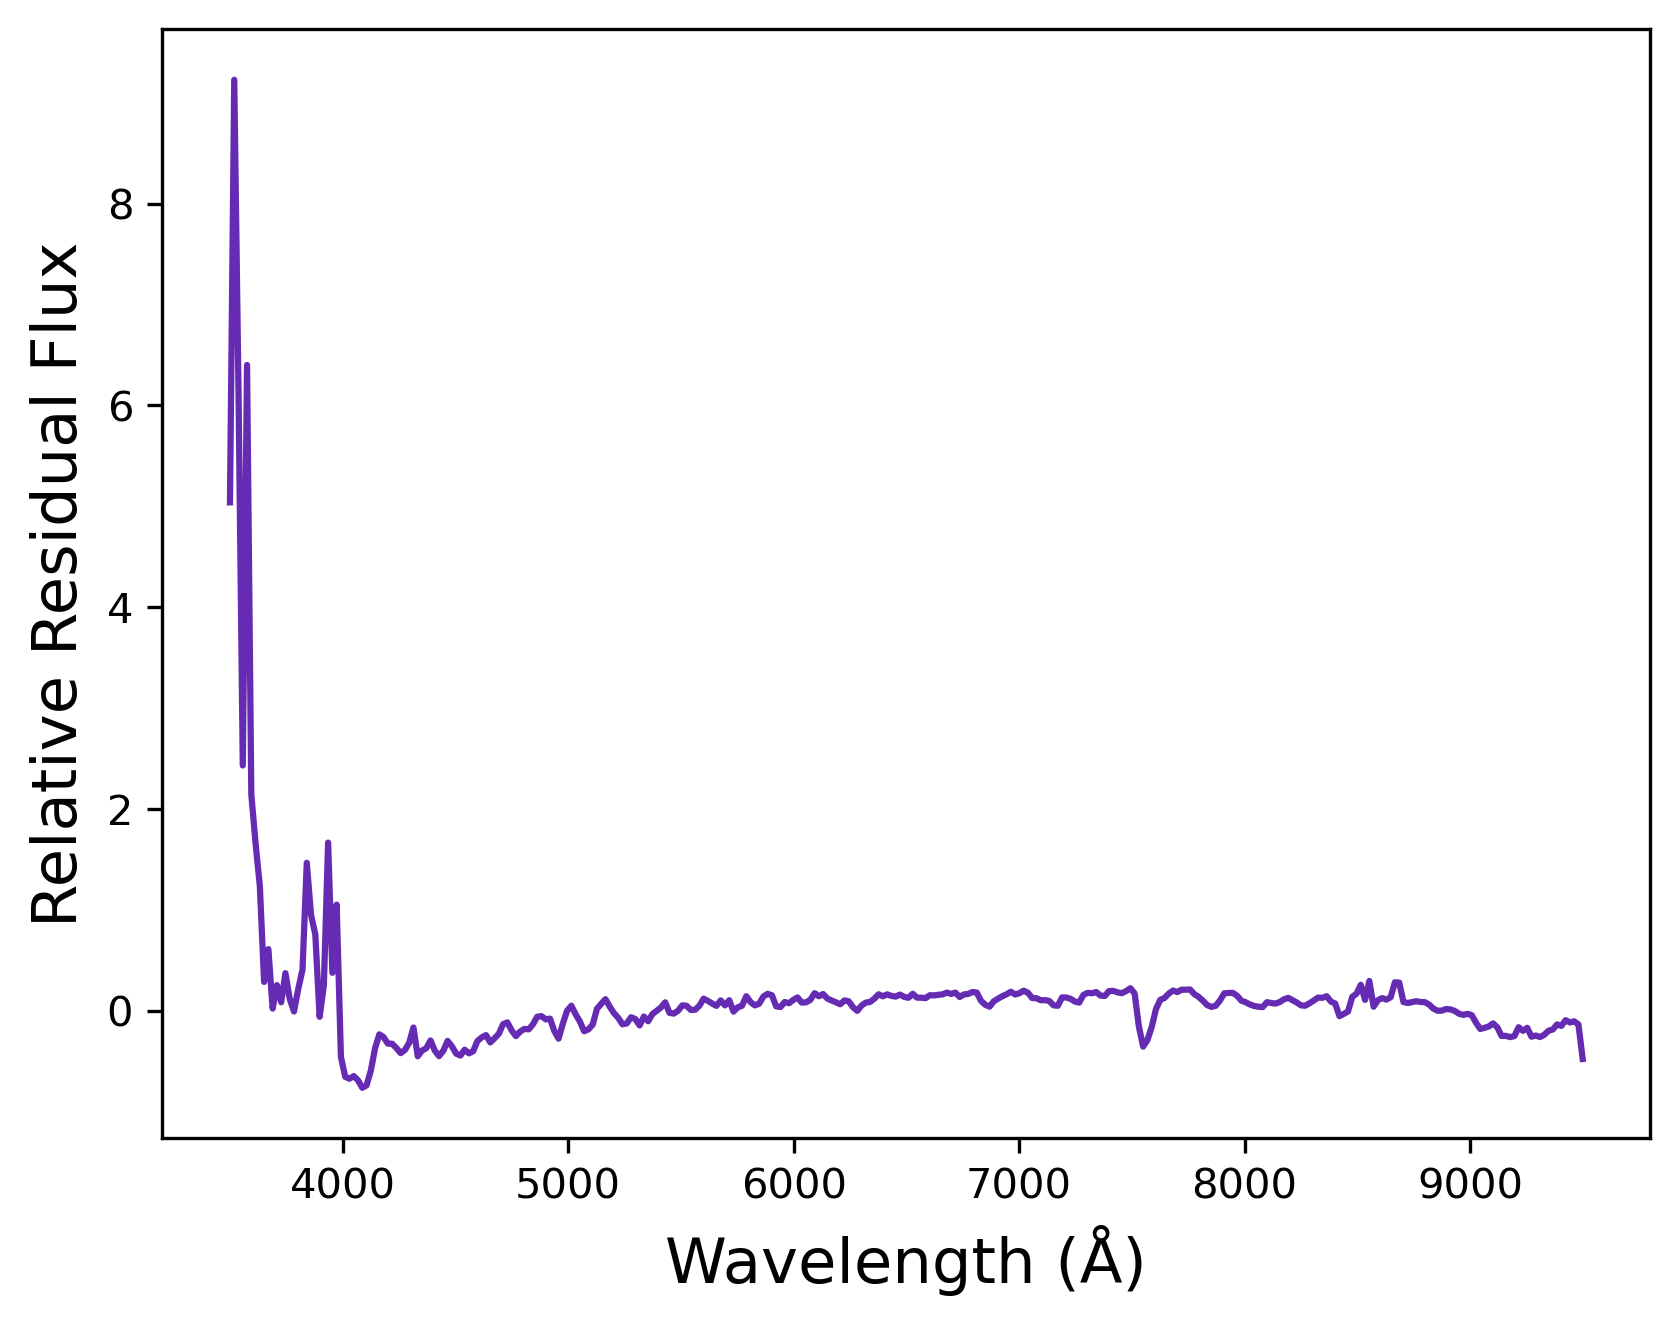

In [41]:
wavelength = np.linspace(3500, 9500, 318)
# for i in range(len(mcfiles_sorted)):
#     warnings.filterwarnings('ignore')
#     binary(wavelength, i)
binary(wavelength, 20)

In [3]:
# print all stars that have/might have binary companion
# list for if it has binary
has_binary = [0,2,4,5,6,9,11,16,17,18,20,22,25,26,27,29,33,34,36,38]
# list for maybe binary
maybe_binary = [1,3,7,10,14,19,21,23,24,28,30,31,32,35,37]
for i in range(len(mcfiles_sorted)):
    warnings.filterwarnings('ignore')
    if i in has_binary:
        binary(wavelength, i)

## Looking at spectra
To confirm the observed results from above, we can look at the original spectra in the blue and see if there is an upturn.

In [32]:
def hilowres(i):#t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    spec_interp, spec1d = smooth(i)

    ax = plt.subplots(dpi=300)[1]
    
    ax.plot(spec1d.spectral_axis.value, spec1d.flux.value, alpha = .5, color='tab:orange')
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value, color='tab:blue', lw=2)
    
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize=15)
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    #plt.plot(wavelength, reddenedmodel_flux)
    plt.show()


This graph is: j05344_122722.fits and array 20


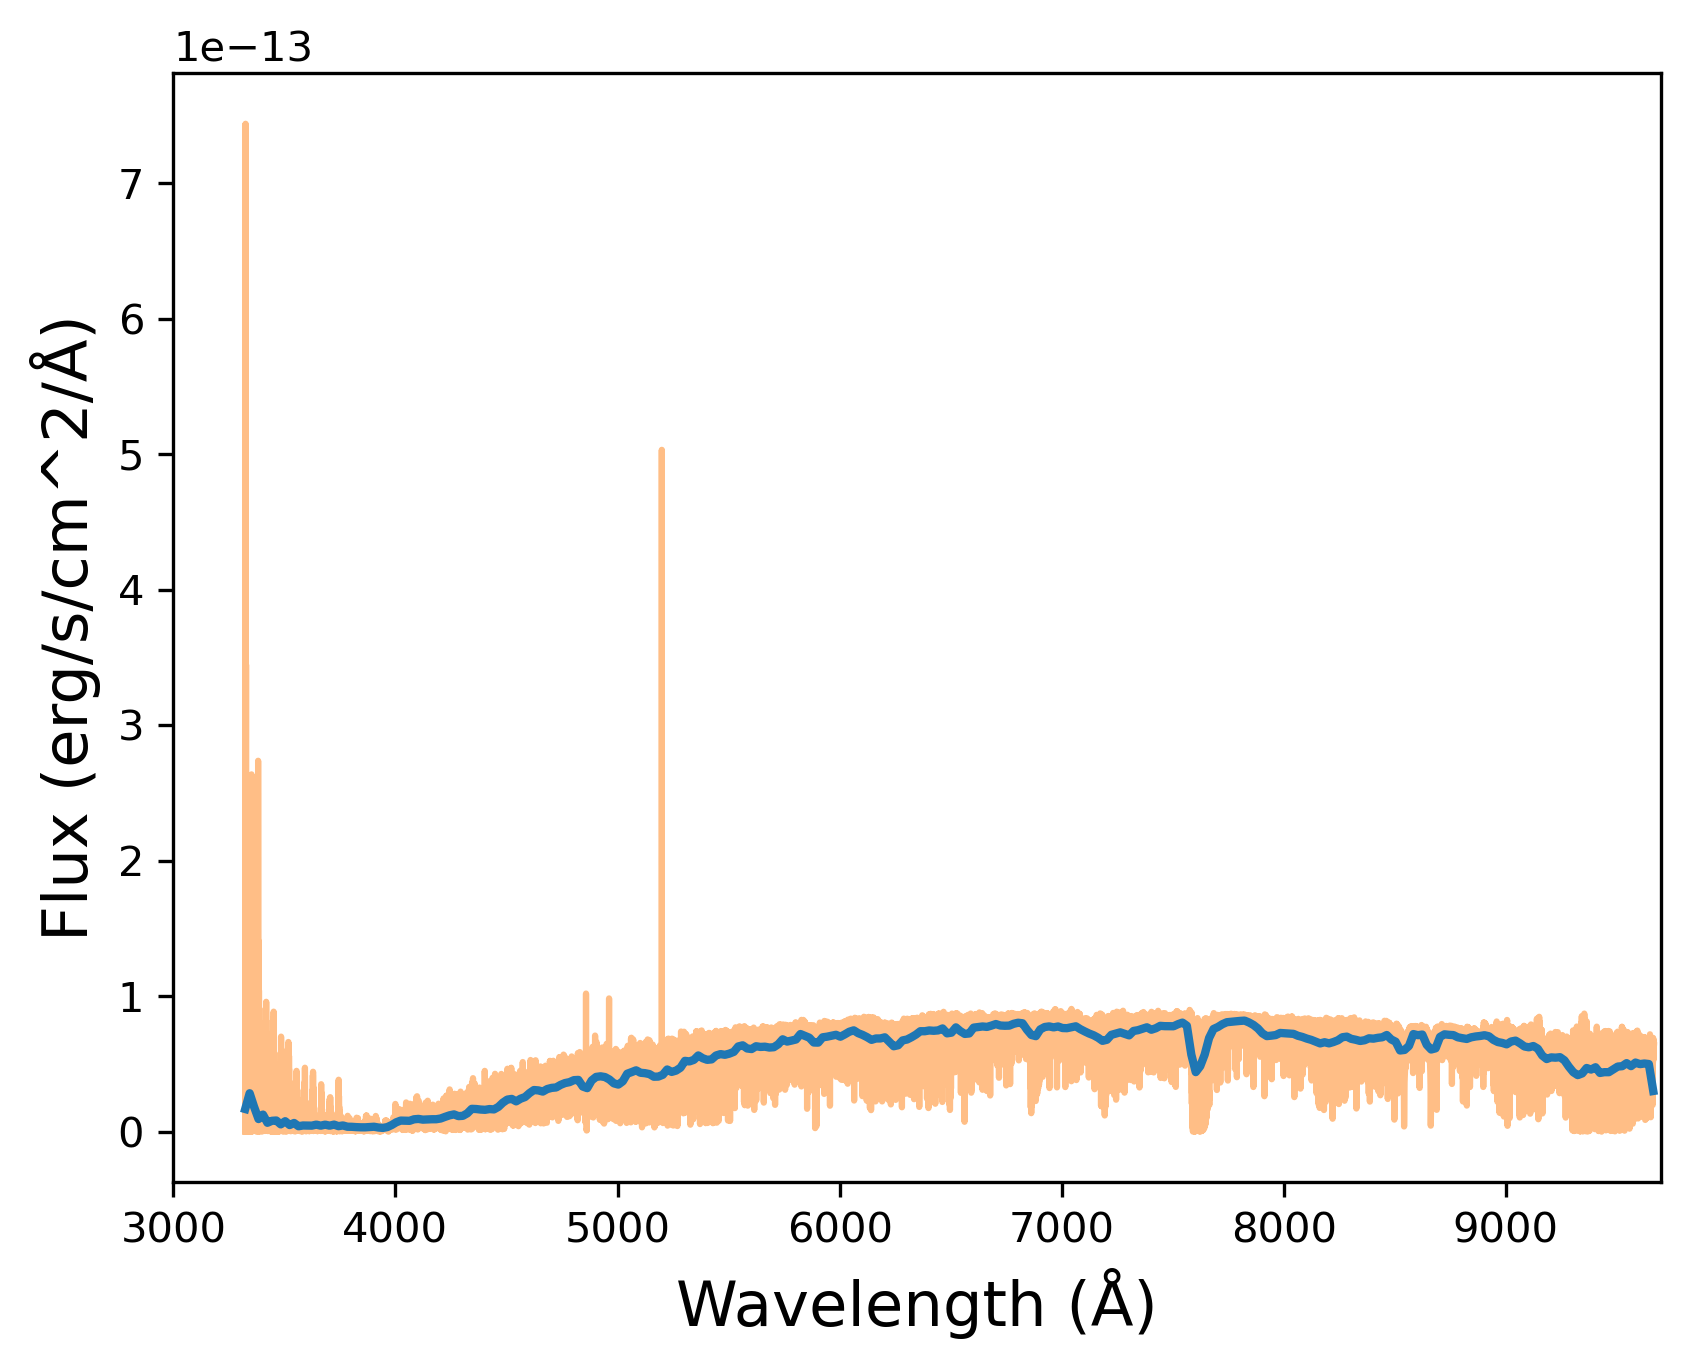

In [33]:
hilowres(20
        )

In [5]:
# list for if it has binary
has_binary = [0,2,4,6,9,11,16,17,18,20,22,25,26,27,29,30,33,34,36,38]
# list for maybe binary
maybe_binary = [1,3,5,7,10,14,19,21,23,24,28,31,32,35,37]
for i in range(len(mcfiles)):
    if (i not in maybe_binary) and (i not in has_binary):
        hilowres(i)

In [ ]:
# plot all with binary star
for i in range(len(mcfiles)):
    if i in has_binary:
        hilowres(i)

This graph is: j05344_122722.fits and array 20


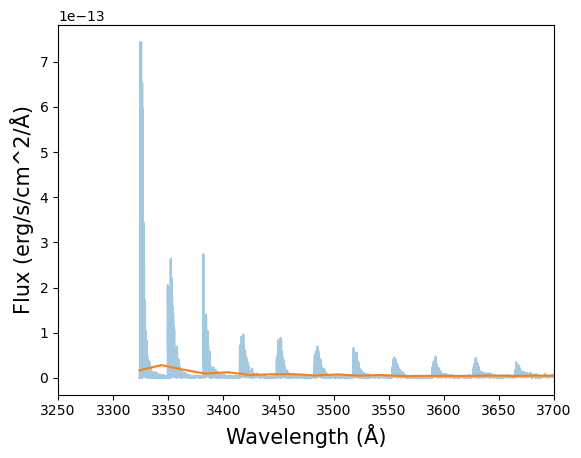

In [136]:
hilowres(20)